In [1]:
%matplotlib inline



# Overview of MEG/EEG analysis with MNE-Python

This tutorial covers the basic EEG/MEG pipeline for event-related analysis:
loading data, epoching, averaging, plotting, and estimating cortical activity
from sensor data. It introduces the core MNE-Python data structures
`~mne.io.Raw`, `~mne.Epochs`, `~mne.Evoked`, and `~mne.SourceEstimate`, and
covers a lot of ground fairly quickly (at the expense of depth). Subsequent
tutorials address each of these topics in greater detail.

We begin by importing the necessary Python modules:


In [2]:
import numpy as np
import mne

## Loading data

MNE-Python data structures are based around the FIF file format from
Neuromag, but there are reader functions for `a wide variety of other
data formats <data-formats>`. MNE-Python also has interfaces to a
variety of `publicly available datasets <datasets>`, which MNE-Python
can download and manage for you.

We'll start this tutorial by loading one of the example datasets (called
"`sample-dataset`"), which contains EEG and MEG data from one subject
performing an audiovisual experiment, along with structural MRI scans for
that subject. The `mne.datasets.sample.data_path` function will automatically
download the dataset if it isn't found in one of the expected locations, then
return the directory path to the dataset (see the documentation of
`~mne.datasets.sample.data_path` for a list of places it checks before
downloading). Note also that for this tutorial to run smoothly on our
servers, we're using a filtered and downsampled version of the data
(:file:`sample_audvis_filt-0-40_raw.fif`), but an unfiltered version
(:file:`sample_audvis_raw.fif`) is also included in the sample dataset and
could be substituted here when running the tutorial locally.



In [3]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file C:\Users\Tianyi Zheng\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


By default, `~mne.io.read_raw_fif` displays some information about the file
it's loading; for example, here it tells us that there are four "projection
items" in the file along with the recorded data; those are :term:`SSP
projectors <projector>` calculated to remove environmental noise from the MEG
signals, plus a projector to mean-reference the EEG channels; these are
discussed in the tutorial `tut-projectors-background`. In addition to
the information displayed during loading, you can get a glimpse of the basic
details of a `~mne.io.Raw` object by printing it; even more is available by
printing its ``info`` attribute (a `dictionary-like object <mne.Info>` that
is preserved across `~mne.io.Raw`, `~mne.Epochs`, and `~mne.Evoked` objects).
The ``info`` data structure keeps track of channel locations, applied
filters, projectors, etc. Notice especially the ``chs`` entry, showing that
MNE-Python detects different sensor types and handles each appropriately. See
`tut-info-class` for more on the `~mne.Info` class.



In [4]:
print(raw)
print(raw.info)

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.3 MB, data not loaded>
<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>


`~mne.io.Raw` objects also have several built-in plotting methods; here we
show the power spectral density (PSD) for each sensor type with
`~mne.io.Raw.plot_psd`, as well as a plot of the raw sensor traces with
`~mne.io.Raw.plot`. In the PSD plot, we'll only plot frequencies below 50 Hz
(since our data are low-pass filtered at 40 Hz). In interactive Python
sessions, `~mne.io.Raw.plot` is interactive and allows scrolling, scaling,
bad channel marking, annotations, projector toggling, etc.



In [5]:
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=30)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)
Using qt as 2D backend.


c:\ProgramData\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


## Preprocessing

MNE-Python supports a variety of preprocessing approaches and techniques
(maxwell filtering, signal-space projection, independent components analysis,
filtering, downsampling, etc); see the full list of capabilities in the
:mod:`mne.preprocessing` and :mod:`mne.filter` submodules. Here we'll clean
up our data by performing independent components analysis
(`~mne.preprocessing.ICA`); for brevity we'll skip the steps that helped us
determined which components best capture the artifacts (see
`tut-artifact-ica` for a detailed walk-through of that process).



Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


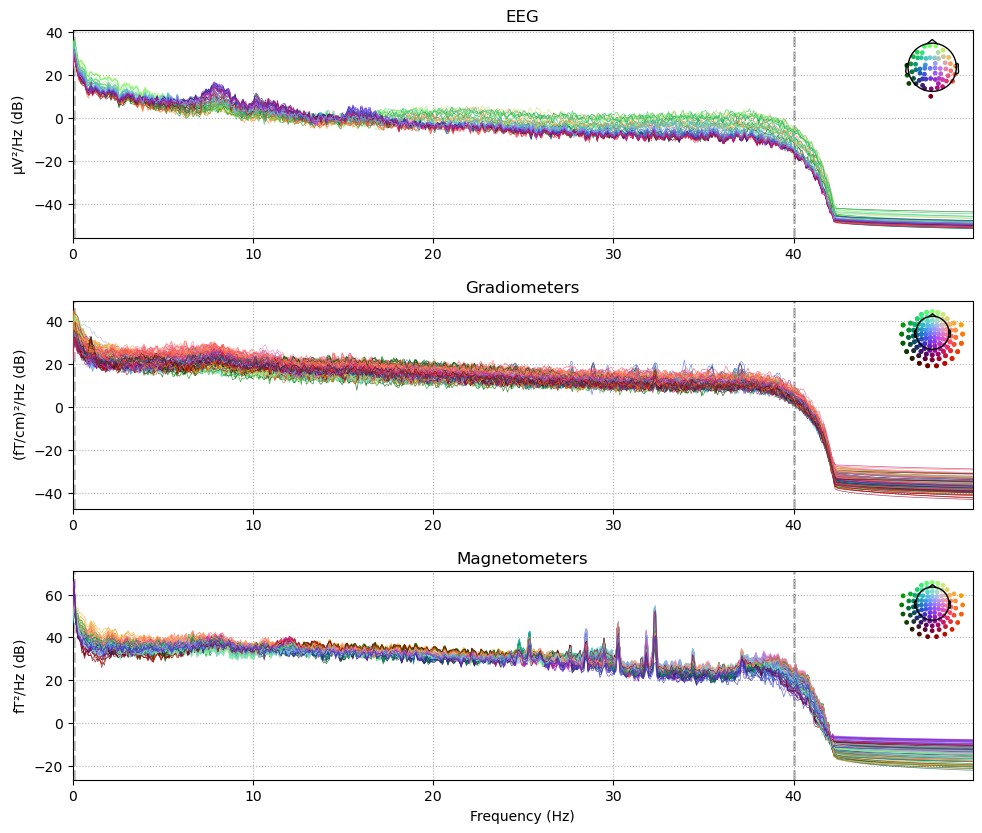

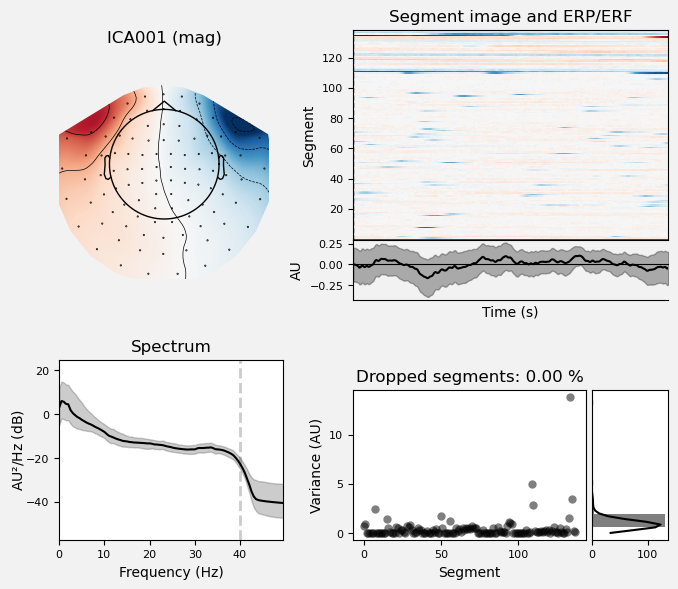

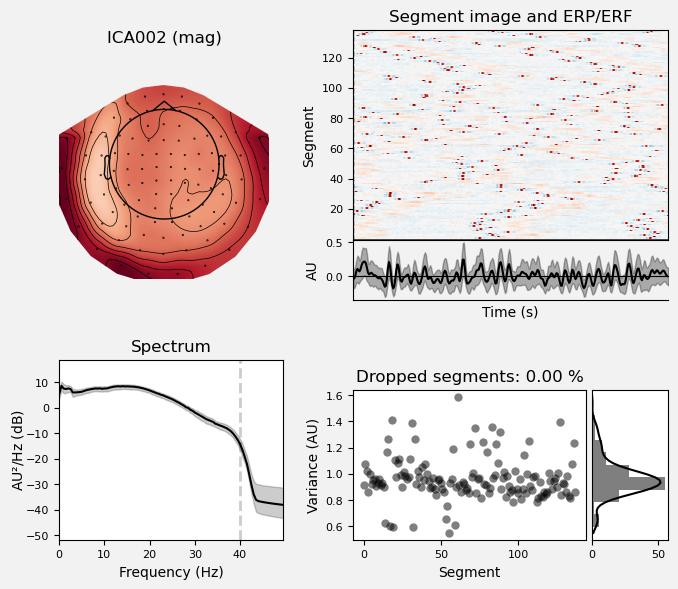

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [6]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

Once we're confident about which component(s) we want to remove, we pass them
as the ``exclude`` parameter and then apply the ICA to the raw signal. The
`~mne.preprocessing.ICA.apply` method requires the raw data to be loaded into
memory (by default it's only read from disk as-needed), so we'll use
`~mne.io.Raw.load_data` first. We'll also make a copy of the `~mne.io.Raw`
object so we can compare the signal before and after artifact removal
side-by-side:



In [7]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components



## Detecting experimental events

The sample dataset includes several :term:`"STIM" channels <stim channel>`
that recorded electrical signals sent from the stimulus delivery computer (as
brief DC shifts / squarewave pulses). These pulses (often called "triggers")
are used in this dataset to mark experimental events: stimulus onset,
stimulus type, and participant response (button press). The individual STIM
channels are combined onto a single channel, in such a way that voltage
levels on that channel can be unambiguously decoded as a particular event
type. On older Neuromag systems (such as that used to record the sample data)
this summation channel was called ``STI 014``, so we can pass that channel
name to the `mne.find_events` function to recover the timing and identity of
the stimulus events.



In [8]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5

319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


The resulting events array is an ordinary 3-column :class:`NumPy array
<numpy.ndarray>`, with sample number in the first column and integer event ID
in the last column; the middle column is usually ignored. Rather than keeping
track of integer event IDs, we can provide an *event dictionary* that maps
the integer IDs to experimental conditions or events. In this dataset, the
mapping looks like this:


+----------+----------------------------------------------------------+
| Event ID | Condition                                                |
+==========+==========================================================+
| 1        | auditory stimulus (tone) to the left ear                 |
+----------+----------------------------------------------------------+
| 2        | auditory stimulus (tone) to the right ear                |
+----------+----------------------------------------------------------+
| 3        | visual stimulus (checkerboard) to the left visual field  |
+----------+----------------------------------------------------------+
| 4        | visual stimulus (checkerboard) to the right visual field |
+----------+----------------------------------------------------------+
| 5        | smiley face (catch trial)                                |
+----------+----------------------------------------------------------+
| 32       | subject button press                                     |
+----------+----------------------------------------------------------+



In [9]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

Event dictionaries like this one are used when extracting epochs from
continuous data; the ``/`` character in the dictionary keys allows pooling
across conditions by requesting partial condition descriptors (i.e.,
requesting ``'auditory'`` will select all epochs with Event IDs 1 and 2;
requesting ``'left'`` will select all epochs with Event IDs 1 and 3). An
example of this is shown in the next section. There is also a convenient
`~mne.viz.plot_events` function for visualizing the distribution of events
across the duration of the recording (to make sure event detection worked as
expected). Here we'll also make use of the `~mne.Info` attribute to get the
sampling frequency of the recording (so our x-axis will be in seconds instead
of in samples).



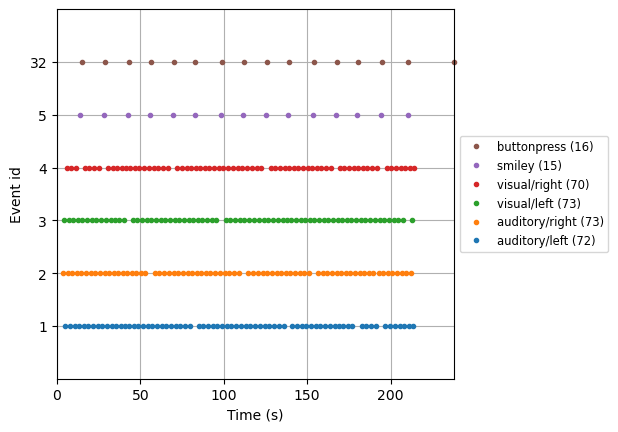

In [10]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

For paradigms that are not event-related (e.g., analysis of resting-state
data), you can extract regularly spaced (possibly overlapping) spans of data
by creating events using `mne.make_fixed_length_events` and then proceeding
with epoching as described in the next section.



## Epoching continuous data

The `~mne.io.Raw` object and the events array are the bare minimum needed to
create an `~mne.Epochs` object, which we create with the `~mne.Epochs` class
constructor. Here we'll also specify some data quality constraints: we'll
reject any epoch where peak-to-peak signal amplitude is beyond reasonable
limits for that channel type. This is done with a *rejection dictionary*; you
may include or omit thresholds for any of the channel types present in your
data. The values given here are reasonable for this particular dataset, but
may need to be adapted for different hardware or recording conditions. For a
more automated approach, consider using the `autoreject package`_.



In [11]:
reject_criteria = dict(mag=4000e-15,     # 4000 fT
                       grad=4000e-13,    # 4000 fT/cm
                       eeg=150e-6,       # 150 µV
                       eog=250e-6)       # 250 µV

We'll also pass the event dictionary as the ``event_id`` parameter (so we can
work with easy-to-pool event labels instead of the integer event IDs), and
specify ``tmin`` and ``tmax`` (the time relative to each event at which to
start and end each epoch). As mentioned above, by default `~mne.io.Raw` and
`~mne.Epochs` data aren't loaded into memory (they're accessed from disk only
when needed), but here we'll force loading into memory using the
``preload=True`` parameter so that we can see the results of the rejection
criteria being applied:



In [12]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
                    reject=reject_criteria, preload=True)

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


Next we'll pool across left/right stimulus presentations so we can compare
auditory versus visual responses. To avoid biasing our signals to the left or
right, we'll use `~mne.Epochs.equalize_event_counts` first to randomly sample
epochs from each condition to match the number of epochs present in the
condition with the fewest good epochs.



In [13]:
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']
del raw, epochs  # free up memory

Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


Like `~mne.io.Raw` objects, `~mne.Epochs` objects also have a number of
built-in plotting methods. One is `~mne.Epochs.plot_image`, which shows each
epoch as one row of an image map, with color representing signal magnitude;
the average evoked response and the sensor location are shown below the
image:



Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


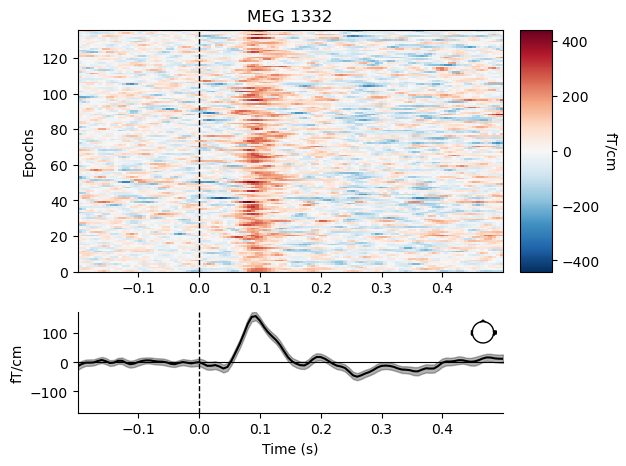

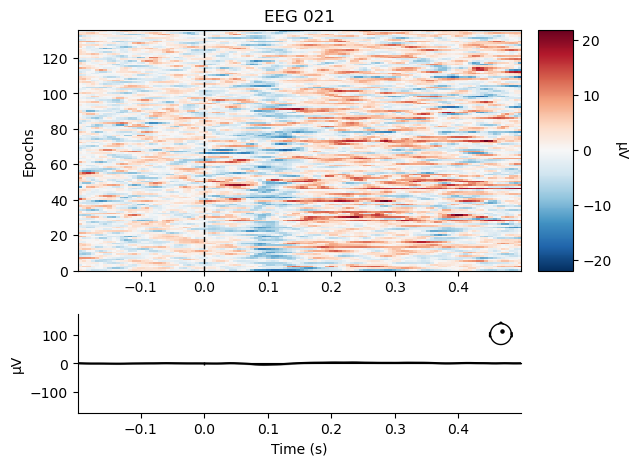

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [14]:
aud_epochs.plot_image(picks=['MEG 1332', 'EEG 021'])

<div class="alert alert-info"><h4>Note</h4><p>Both `~mne.io.Raw` and `~mne.Epochs` objects have `~mne.Epochs.get_data`
    methods that return the underlying data as a
    :class:`NumPy array <numpy.ndarray>`. Both methods have a ``picks``
    parameter for subselecting which channel(s) to return; ``raw.get_data()``
    has additional parameters for restricting the time domain. The resulting
    matrices have dimension ``(n_channels, n_times)`` for `~mne.io.Raw` and
    ``(n_epochs, n_channels, n_times)`` for `~mne.Epochs`.</p></div>

## Time-frequency analysis

The :mod:`mne.time_frequency` submodule provides implementations of several
algorithms to compute time-frequency representations, power spectral density,
and cross-spectral density. Here, for example, we'll compute for the auditory
epochs the induced power at different frequencies and times, using Morlet
wavelets. On this dataset the result is not especially informative (it just
shows the evoked "auditory N100" response); see `here
<inter-trial-coherence>` for a more extended example on a dataset with richer
frequency content.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
No baseline correction applied


[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:    4.2s finished


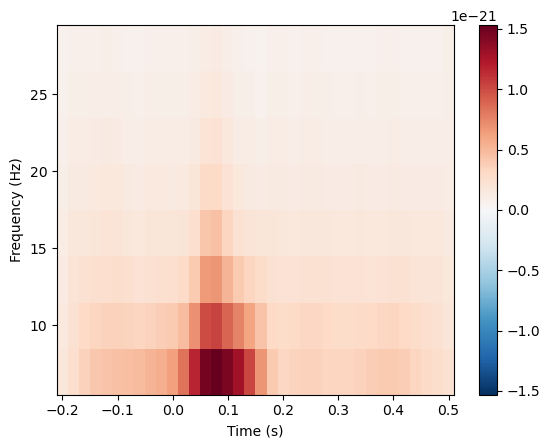

[<Figure size 640x480 with 2 Axes>]

In [15]:
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(aud_epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)
power.plot(['MEG 1332'])

## Estimating evoked responses

Now that we have our conditions in ``aud_epochs`` and ``vis_epochs``, we can
get an estimate of evoked responses to auditory versus visual stimuli by
averaging together the epochs in each condition. This is as simple as calling
the `~mne.Epochs.average` method on the `~mne.Epochs` object, and then using
a function from the :mod:`mne.viz` module to compare the global field power
for each sensor type of the two `~mne.Evoked` objects:



Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"


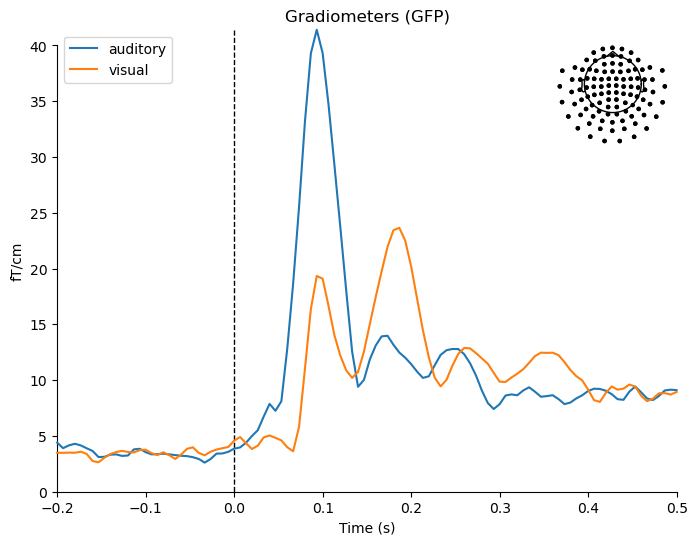

combining channels using "gfp"
combining channels using "gfp"


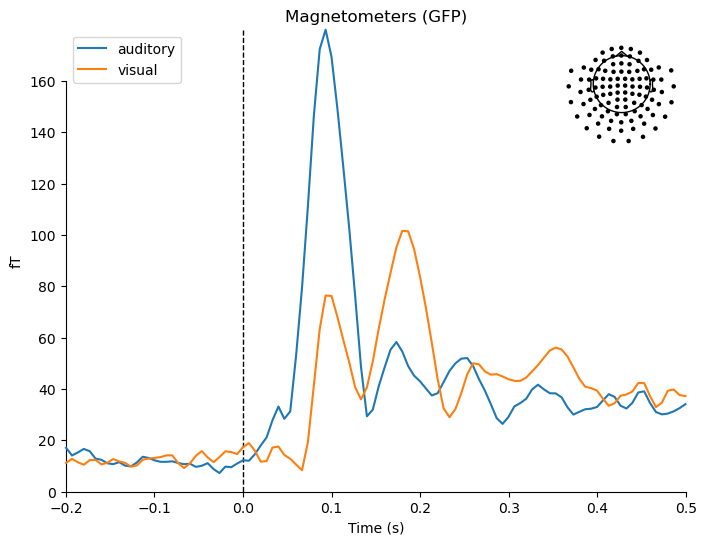

combining channels using "gfp"
combining channels using "gfp"


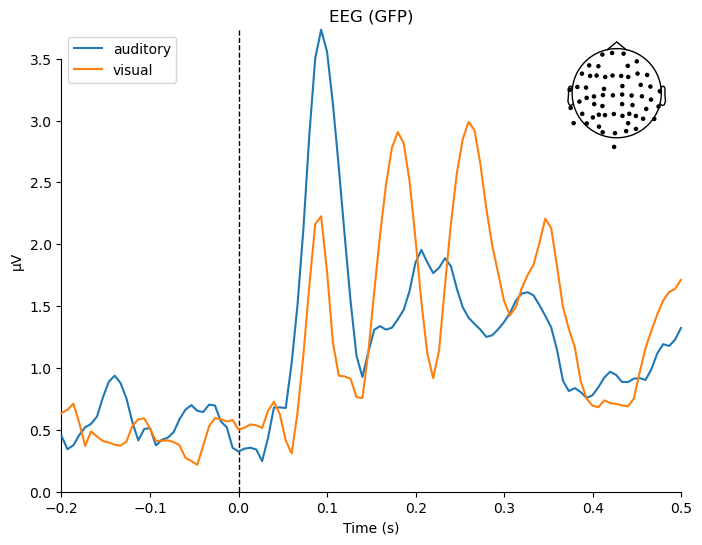

[<Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>]

In [16]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')

We can also get a more detailed view of each `~mne.Evoked` object using other
plotting methods such as `~mne.Evoked.plot_joint` or
`~mne.Evoked.plot_topomap`. Here we'll examine just the EEG channels, and see
the classic auditory evoked N100-P200 pattern over dorso-frontal electrodes,
then plot scalp topographies at some additional arbitrary times:



Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


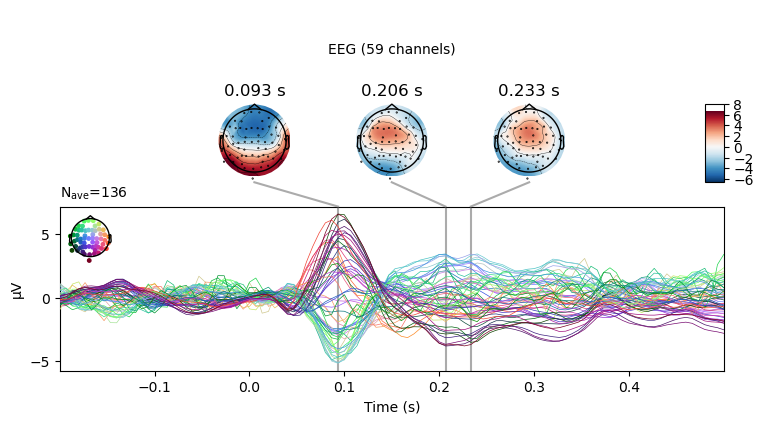

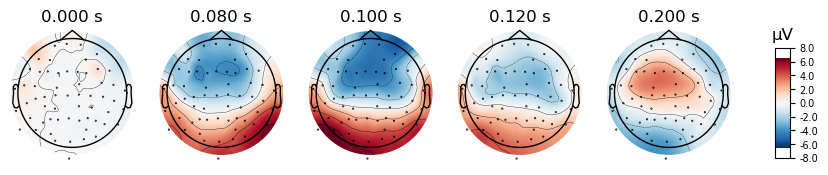

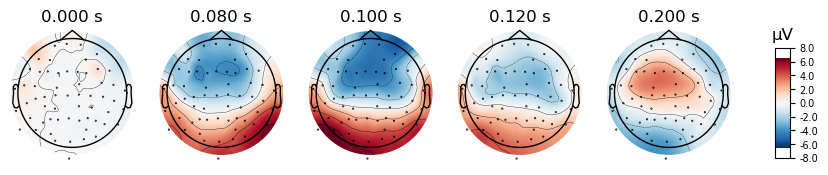

In [17]:
aud_evoked.plot_joint(picks='eeg')
aud_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')

Evoked objects can also be combined to show contrasts between conditions,
using the `mne.combine_evoked` function. A simple difference can be
generated by passing ``weights=[1, -1]``. We'll then plot the difference wave
at each sensor using `~mne.Evoked.plot_topo`:



Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


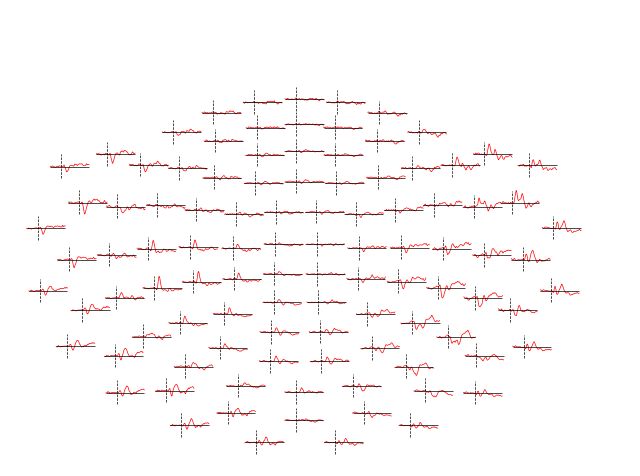

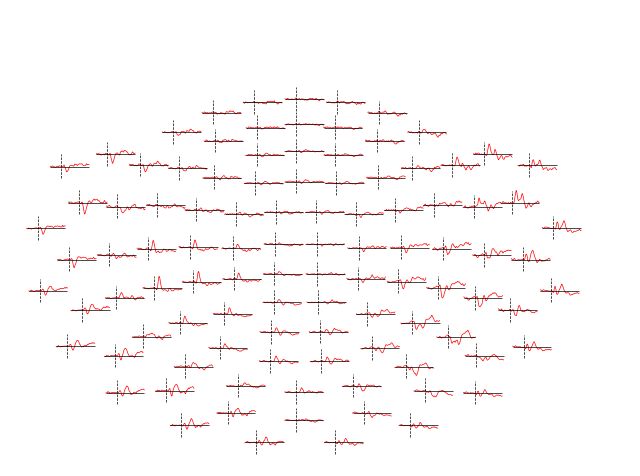

In [18]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick_types(meg='mag').plot_topo(color='r', legend=False)

## Inverse modeling

Finally, we can estimate the origins of the evoked activity by projecting the
sensor data into this subject's :term:`source space` (a set of points either
on the cortical surface or within the cortical volume of that subject, as
estimated by structural MRI scans). MNE-Python supports lots of ways of doing
this (dynamic statistical parametric mapping, dipole fitting, beamformers,
etc.); here we'll use minimum-norm estimation (MNE) to generate a continuous
map of activation constrained to the cortical surface. MNE uses a linear
:term:`inverse operator` to project EEG+MEG sensor measurements into the
source space. The inverse operator is computed from the
:term:`forward solution` for this subject and an estimate of `the
covariance of sensor measurements <tut-compute-covariance>`. For this
tutorial we'll skip those computational steps and load a pre-computed inverse
operator from disk (it's included with the `sample data
<sample-dataset>`). Because this "inverse problem" is underdetermined (there
is no unique solution), here we further constrain the solution by providing a
regularization parameter specifying the relative smoothness of the current
estimates in terms of a signal-to-noise ratio (where "noise" here is akin to
baseline activity level across all of cortex).



In [19]:
# load inverse operator
inverse_operator_file = (sample_data_folder / 'MEG' / 'sample' /
                         'sample_audvis-meg-oct-6-meg-inv.fif')
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)
# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.
lambda2 = 1. / snr ** 2
# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(vis_evoked, inv_operator,
                                     lambda2=lambda2,
                                     method='MNE')  # or dSPM, sLORETA, eLORETA

Reading inverse operator decomposition from C:\Users\Tianyi Zheng\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Com

Finally, in order to plot the source estimate on the subject's cortical
surface we'll also need the path to the sample subject's structural MRI files
(the ``subjects_dir``):



In [20]:
# path to subjects' MRI files
subjects_dir = sample_data_folder / 'subjects'
# plot the STC
stc.plot(initial_time=0.1, hemi='split', views=['lat', 'med'],
         subjects_dir=subjects_dir)

Using pyvistaqt 3d backend.

Using control points [8.61922423e-11 1.06837855e-10 4.49139511e-10]


Channels marked as bad:
['MEG 2443', 'EEG 053']
Channels marked as bad:
['MEG 2443', 'EEG 053']
Channels marked as bad:
['MEG 2443', 'EEG 053']


The remaining tutorials have *much more detail* on each of these topics (as
well as many other capabilities of MNE-Python not mentioned here:
connectivity analysis, encoding/decoding models, lots more visualization
options, etc). Read on to learn more!

.. LINKS


